In [ ]:
import json

# Path to your JSON file
json_path = r"\\bear-ad.cs.fiu.edu\homes\Downloads\MMHS150K_GT.json"

# Function to load JSON data
def load_json_data(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

# Load your dataset's metadata
metadata = load_json_data(json_path)

In [ ]:
#ORGANISING IMAGES BY IDS
def load_ids(file_path):
    with open(file_path, 'r') as file:
        ids = file.read().splitlines()
    return ids

train_ids = load_ids(r"\\bear-ad.cs.fiu.edu\homes\Downloads\splits\splits\train_ids.txt")
val_ids = load_ids(r"\\bear-ad.cs.fiu.edu\homes\Downloads\splits\splits\val_ids.txt")
test_ids = load_ids(r"\\bear-ad.cs.fiu.edu\homes\Downloads\splits\splits\test_ids.txt")

import os
import shutil

def organize_images_by_ids(source_dir, destination_dir, ids):
    os.makedirs(destination_dir, exist_ok=True)  # Create the destination directory if it doesn't exist
    for img_id in ids:
        src_path = os.path.join(source_dir, img_id + '.jpg')  # Assuming images are in JPG format
        dst_path = os.path.join(destination_dir, img_id + '.jpg')
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Image {img_id}.jpg not found in {source_dir}")

organize_images_by_ids(r"\\bear-ad.cs.fiu.edu\homes\Downloads\img_resized\img_resized", r"\\bear-ad.cs.fiu.edu\homes\Downloads\train_imgs", train_ids)  #134823 images are present here
organize_images_by_ids(r"\\bear-ad.cs.fiu.edu\homes\Downloads\img_resized\img_resized", r"\\bear-ad.cs.fiu.edu\homes\Downloads\val_imgs", val_ids) #5000 images are present here
organize_images_by_ids(r"\\bear-ad.cs.fiu.edu\homes\Downloads\img_resized\img_resized", r"\\bear-ad.cs.fiu.edu\homes\Downloads\test_imgs", test_ids)  #10000 images are present here

In [ ]:
#Ensuring count
import os

def count_images(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}  # Add or remove extensions as needed
    image_count = 0

    for root, dirs, files in os.walk(directory):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_count += 1

    return image_count

directory_path = r"\\bear-ad.cs.fiu.edu\homes\Downloads\train_imgs"
total_images = count_images(directory_path)
print(f"Total images found in {directory_path}: {total_images}")

In [ ]:
#Clearing the folders before segmenting them

import shutil
import os

# Define your destination root and the class directories
destination_root =  r"\\bear-ad.cs.fiu.edu\homes\Downloads\class"
class_directories = ['0', '1', '2', '3', '4', '5']

# Function to clear directories
def clear_directories(root_dir, sub_dirs):
    for sub_dir in sub_dirs:
        full_path = os.path.join(root_dir, sub_dir)
        if os.path.exists(full_path):
            shutil.rmtree(full_path)  # Remove the directory and all its contents
            os.makedirs(full_path)  # Recreate the directory empty
            print(f"Cleared and recreated {full_path}")
        else:
            os.makedirs(full_path)  # If the directory does not exist, create it
            print(f"Created {full_path}")

# Clear (or create) directories for 'train', 'val', 'test' sets
for set_name in ['train', 'val', 'test']:
    set_path = os.path.join(destination_root, set_name)
    clear_directories(set_path, class_directories)

In [ ]:
#To create hate folders by combining class 2 through class 5

import os
import shutil

def move_images_to_folder(source_root, target_label):
    """
    Move images from folders 2-5 into the folder with `target_label`,
    while leaving images in folder 0 as they are.
    """
    for label in range(2, 6):  # Assuming labels 2 through 5
        source_dir = os.path.join(source_root, str(label))
        target_dir = os.path.join(source_root, str(target_label))
        if not os.path.exists(target_dir):
            os.makedirs(target_dir, exist_ok=True)

        for img_name in os.listdir(source_dir):
            src_path = os.path.join(source_dir, img_name)
            dest_path = os.path.join(target_dir, img_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dest_path)
            else:
                print(f"Image {img_name} not found in {source_dir}")

    # After moving images from folders 2-5, delete those folders
    for label in range(2, 6):
        folder_to_delete = os.path.join(source_root, str(label))
        if os.path.exists(folder_to_delete):
            shutil.rmtree(folder_to_delete)
            print(f"Folder {folder_to_delete} deleted.")

# Example usage:
destination_root = r"\\bear-ad.cs.fiu.edu\homes\Downloads\class"
sets = ['train', 'val', 'test']

for set_name in sets:
    set_path = os.path.join(destination_root, set_name)
    print(f"Moving {set_name} images...")
    move_images_to_folder(set_path, 1)


In [ ]:
#ensuring the count
import os

# Path to your datasets
destination_root = r"\\bear-ad.cs.fiu.edu\homes\Downloads\class"
# Define your dataset partitions
sets = ['train', 'test', 'val']
# Subdirectories within each dataset partition, now including '0'
sub_dirs = ['0', '1', '2', '3', '4', '5']

def count_files_in_subdirs(root_dir, dataset_partitions, subdirectories):
    for partition in dataset_partitions:
        print(f"Counting files in {partition} set:")
        total_files = 0
        for sub_dir in subdirectories:
            subdir_path = os.path.join(root_dir, partition, sub_dir)
            if os.path.exists(subdir_path):
                num_files = len([name for name in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, name))])
                print(f" - {sub_dir}: {num_files} files")
                total_files += num_files
        print(f"Total files in {partition} set: {total_files}\n")

count_files_in_subdirs(destination_root, sets, sub_dirs)

In [ ]:
#Getting Training Features


import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# Load the Inception V3 model pre-trained on ImageNet data, excluding the top (classification) layer
base_model = InceptionV3(weights='imagenet', include_top=False)

# Ensure the output is the 2048-dimensional vector after the global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # This ensures the output is 2048-dimensional
model = Model(inputs=base_model.input, outputs=x)

# Setup the ImageDataGenerator for preprocessing
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Define batch size
batch_size = 32

def process_and_save_features_and_labels(generator, model, features_file_template, labels_file_template, num_images, batch_size=32):
    steps = np.ceil(num_images / batch_size)
    processed_images = 0

    for i in tqdm(range(int(steps)), desc="Processing training batches"):
        # Ensure we don't fetch more images than we have left
        actual_batch_size = min(batch_size, num_images - processed_images)
        try:
            batch, labels_batch = next(generator)
            features_batch = model.predict(batch, batch_size=actual_batch_size)
        except ValueError as e:
            print(f"Error processing batch {i+1}: {e}")
            break

        processed_images += actual_batch_size
        print(f"Processed {processed_images} of {num_images} training images")

        # Save features and labels of the current batch
        np.save(features_file_template.format(i), features_batch)
        np.save(labels_file_template.format(i), labels_batch)

# Make sure your train_generator is properly configured to yield labels
train_generator = data_gen.flow_from_directory(
    r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',  
    shuffle=False
)

num_train_images = 134823  

# Assuming `model` is your InceptionV3 model configured for feature extraction
process_and_save_features_and_labels(train_generator, model, r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_features_batch_{:04d}.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_labels_batch_{:04d}.npy", num_train_images, batch_size=32)

#Combine train features and labels
def combine_saved_batches(features_file_pattern, labels_file_pattern, combined_features_file, combined_labels_file, num_batches):
    all_features = []
    all_labels = []

    for i in tqdm(range(num_batches), desc="Combining training batches"):
        batch_features = np.load(features_file_pattern.format(i))
        batch_labels = np.load(labels_file_pattern.format(i))

        all_features.append(batch_features)
        all_labels.append(batch_labels)

    # Concatenate all batches
    combined_features = np.concatenate(all_features, axis=0)
    combined_labels = np.concatenate(all_labels, axis=0)

    # Save the combined arrays
    np.save(combined_features_file, combined_features)
    np.save(combined_labels_file, combined_labels)

num_batches = int(np.ceil(num_train_images / 32))  # Adjust batch_size if different
combine_saved_batches(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_features_batch_{:04d}.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_labels_batch_{:04d}.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_features_combined.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_labels_combined.npy", num_batches)



import numpy as np

# Load the features without trying to impose a shape
train_features = np.load(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_features_combined.npy")
train_labels=np.load(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\train_labels_combined.npy")


In [ ]:
#Getting Validation Features
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# Load the Inception V3 model pre-trained on ImageNet data, excluding the top (classification) layer
base_model = InceptionV3(weights='imagenet', include_top=False)

# Ensure the output is the 2048-dimensional vector after the global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # This ensures the output is 2048-dimensional
model = Model(inputs=base_model.input, outputs=x)

# Setup the ImageDataGenerator for preprocessing
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Define batch size
batch_size = 32
val_generator = data_gen.flow_from_directory(
    r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
def process_and_save_val_features_and_labels(generator, model, features_file_template, labels_file_template, num_images, batch_size=32):
    steps = np.ceil(num_images / batch_size)
    processed_images = 0

    for i in tqdm(range(int(steps)), desc="Processing validation batches"):
        # Retrieve the next batch; adjust for the last batch which might be smaller
        actual_batch_size = min(batch_size, num_images - processed_images)
        try:
            batch, labels_batch = next(generator)
            features_batch = model.predict(batch, batch_size=actual_batch_size)
        except ValueError as e:
            print(f"Error processing batch {i+1}: {e}")
            break

        processed_images += actual_batch_size
        print(f"Processed {processed_images} of {num_images} validation images")

        # Save features and labels of the current batch
        np.save(features_file_template.format(i), features_batch)
        np.save(labels_file_template.format(i), labels_batch)




# Update these numbers to reflect your actual dataset
#num_train_images = 134823
num_val_images = 5000

# Extract features and labels
process_and_save_val_features_and_labels(val_generator, model, r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_features_batch_{:04d}.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_labels_batch_{:04d}.npy", num_val_images)


import numpy as np
from tqdm import tqdm
import glob

def combine_saved_batches(features_file_pattern, labels_file_pattern, combined_features_file, combined_labels_file, num_batches):
    all_features = []
    all_labels = []

    for i in tqdm(range(num_batches), desc="Combining batches"):
        batch_features = np.load(features_file_pattern.format(i))
        batch_labels = np.load(labels_file_pattern.format(i))

        all_features.append(batch_features)
        all_labels.append(batch_labels)

    # Concatenate all batches
    combined_features = np.concatenate(all_features, axis=0)
    combined_labels = np.concatenate(all_labels, axis=0)

    # Save the combined arrays
    np.save(combined_features_file, combined_features)
    np.save(combined_labels_file, combined_labels)

# Calculate number of batches based on your num_val_images and batch_size
num_batches = int(np.ceil(num_val_images / 32))  # Adjust batch_size if different

# Call the function to combine batches
combine_saved_batches(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_features_batch_{:04d}.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_labels_batch_{:04d}.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_features_combined.npy", r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_labels_combined.npy", num_batches) 

In [ ]:
#Random Sampling
from imblearn.over_sampling import RandomOverSampler

# Assuming you have the counts of each class
class_counts = {0: 105344, 1: 29479}

# Calculate the maximum class count
max_class_count = max(class_counts.values())

# Resample the minority class (class 1 in this case) to match the maximum class count
resampler = RandomOverSampler(sampling_strategy={0: max_class_count, 1: max_class_count})
X_resampled, y_resampled = resampler.fit_resample(train_features, train_labels)

# Check the counts after resampling
resampled_class_counts = dict(zip(*np.unique(y_resampled, return_counts=True)))
print("Resampled class distribution:")
for label, count in resampled_class_counts.items():
    print(f"- {label}: {count} files")

# Now, X_resampled and y_resampled contain the resampled training data

import os
import numpy as np

# Define the directory where you want to save the resampled data
output_dir = r"\\bear-ad.cs.fiu.edu\homes\Downloads\Resampled"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save X_resampled and y_resampled as numpy arrays
np.save(os.path.join(output_dir, 'X_resampled.npy'), X_resampled)
np.save(os.path.join(output_dir, 'y_resampled.npy'), y_resampled)

In [ ]:
#Model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load resampled training data
X_resampled = np.load(r"\\bear-ad.cs.fiu.edu\homes\Downloads\Resampled\X_resampled.npy")
y_resampled = np.load(r"\\bear-ad.cs.fiu.edu\homes\Downloads\Resampled\y_resampled.npy")

# Model definition
model = Sequential([
    Dense(1024, activation='relu', input_shape=(2048,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=1e-6, mode='max', verbose=1)

# Assuming you also have validation features and labels loaded similarly
val_features = np.load(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_features_combined.npy")
val_labels = np.load(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\val_labels_combined.npy")

# Train the model
history = model.fit(X_resampled, y_resampled,
                    validation_data=(val_features, val_labels),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)


# After training the model as specified in the previous step

# Define the path where you want to save the model
model_save_path = r"\\bear-ad.cs.fiu.edu\homes\Downloads\Resampled\my_binary_classification_model.h5"

# Save the model
model.save(model_save_path)

print(f"Model saved successfully at {model_save_path}")

In [ ]:
#Test evaluation, feature & label extraction,saving it 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Initialize the test data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Prepare the test data generator
test_generator = test_datagen.flow_from_directory(
    r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\test",  # Make sure this is the path to your test images
    target_size=(299, 299),
    batch_size=32,  # Match with the batch size used during feature extraction
    class_mode='binary',  # Since it's binary classification
    shuffle=False  # Important to keep the order for labels to match up with the features
)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the base InceptionV3 model, excluding the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # This converts the MxNx2048 tensor into a 2048-dimensional vector per image

# Define the new model
feature_extractor = Model(inputs=base_model.input, outputs=x)

In [ ]:
import numpy as np

# Extract features and labels
features = []
labels = []

# Iterate over the generator
for i in range(len(test_generator)):
    batch_imgs, batch_labels = next(test_generator)
    batch_features = feature_extractor.predict(batch_imgs)
    features.append(batch_features)
    labels.append(batch_labels)
    
    # Early stopping condition since the generator loops indefinitely
    if i >= (test_generator.samples // test_generator.batch_size) - 1:
        break

# Convert lists to numpy arrays
test_features = np.vstack(features)  # This stacks arrays vertically, resulting in a shape (num_samples, 2048)
test_labels = np.concatenate(labels)  # This concatenates label arrays

np.save(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\test_features.npy", test_features)
np.save(r"\\bear-ad.cs.fiu.edu\homes\Downloads\class\test_labels.npy", test_labels)

In [ ]:
# Load your model
model = load_model(model_path)

# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(test_features, test_labels)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")


# Assuming test_features are your test set features
y_pred_probs = model.predict(test_features)


from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc}")


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

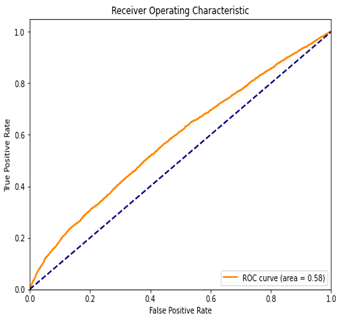

In [ ]:
#Normalized Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_features)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = np.where(y_pred_probs > 0.5, 1, 0).flatten()


# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Normalized Confusion Matrix:")
print(cm_normalized)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Normalized Confusion Matrix')
plt.show()

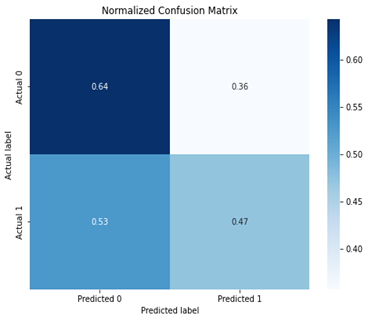